What is the difference between map, apply, apply map

* apply
    * This method defined in both Series and DataFrame
    * Accept callables only
    * apply() also works elementwise but is suited to more complex operations and aggregation.
    * DataFrame.apply() operates on entire rows or columns at a time.
    * Series.apply() operate on one element at time
* map
     * map() accepts dicts, Series, or callable
     * You can use this to perform operations on a specific column of a DataFrame as each column in a DataFrame is Series.
     * Series.map() operate on one element at time
* applymap

    * Accept callables only.
    * applymap() is elementwise for DataFrames.
    * applymap() performs better than apply().
    * applymap() operates on one element at time


In [80]:
def sclean(s):
    parts = s.split("d ")
    day  = int(parts[0])
    time = parts[1]
    z=sum(x * float(t) for x, t in zip([1/60, 1, 60], reversed(time.split(":"))))+day*1440
    return z

def tweak(df,u,t):
    return (df
           .assign(Stime = lambda df_:df_['StepTime'].map(sclean), UUT=u, Test= t)
           .drop('StepTime', axis=1)
           )

In [81]:
import glob
import re
import pandas as pd
import numpy as np

trans={"U01":"Vendor","U02":"FW1","U03":"FW2","U04":"LT1","U05":"LT2","U06":"LH1","U07":"LH2"}
data_files = [f for f in glob.glob("Data/*.txt")]
dfs = []
for x in data_files:
    uut = "U"+re.search('_U(.+?)_', x)[1]
    tst = trans[uut]
    df = pd.read_csv(x, skiprows=4,sep="\t", header=0, usecols=[0,1,2,4,5,7,8,9],index_col=0)
    df = tweak(df,uut,tst)
    dfs.append(df)
df = pd.concat(dfs)

In [82]:
df


,Cyc#,Step,Amp-hr,Amps,Volts,State,Stime,UUT,Test
Rec#,,,,,,,,,
1,0,1,0.0,0.00000,3.53414,R,0.000000,U01,Vendor
2,0,1,0.0,0.00000,3.49775,R,1.000000,U01,Vendor
3,1,4,0.0,0.00007,3.49744,D,0.000833,U01,Vendor
4,1,4,0.0,0.00375,2.60517,D,0.006833,U01,Vendor
5,1,5,0.0,0.00000,0.00000,R,0.000167,U01,Vendor
...,...,...,...,...,...,...,...,...,...
55054,18,9,0.0,0.00000,4.08606,R,2234.000167,U07,LH2
55055,18,9,0.0,0.00000,4.08614,R,2235.000167,U07,LH2
55056,18,9,0.0,0.00000,4.08614,R,2236.000167,U07,LH2


Now that we have clean data, we can talk about how to analyze it.

In [155]:
dis = (df[df['Step']==4]
       .groupby(['UUT'])
       .agg({"Amp-hr":"max"})
       )
z=dict(dis.reset_index().values)

discharge = (df[df['Step']==4]
            .groupby(['UUT','Cyc#'])
            .agg({"Amp-hr":"max"})
            .reset_index()
            .query('UUT != "U06" and UUT != "U07"')
            .assign(Ah  = lambda df_:df_['Amp-hr']/df_['UUT'].map(z))
            .drop("Amp-hr",axis=1)
            )

In [156]:
discharge

,UUT,Cyc#,Ah
0,U01,1,0.000000
1,U01,2,0.000000
2,U01,3,0.000000
3,U01,4,0.000000
4,U01,5,0.000000
...,...,...,...
1087,U05,269,0.560344
1088,U05,270,0.507151
1089,U05,271,0.847241
1090,U05,272,0.847076


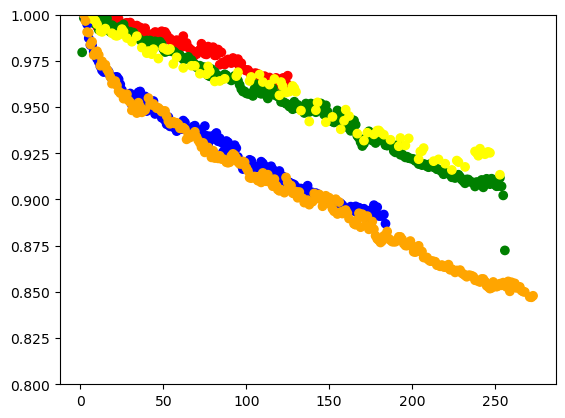

In [157]:
import matplotlib.pyplot as plt
import numpy as np
d=discharge
fig, ax = plt.subplots()

colors = {'U01':'red', 'U02':'green', 'U03':'blue', 'U04':'yellow','U05':'orange'}
ax.set_ylim([0.8, 1])

ax.scatter(d['Cyc#'], d['Ah'], c=d['UUT'].map(colors))

plt.show()